Model teste from https://buildingenergygeeks.org/a-simple-rc-model-python.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.interpolate import interp1d

In [38]:
path = r"C:\Users\Alexandra\Documents\TEE-etoile\ProCom\donnes_modele_RC.csv"
df = pd.read_csv(path, delimiter = ',')

df['P'] = df['P']/1000
df['Radiation'] = df['Radiation']/1000
df['Tin'] = df['Tin']

print(df.head)


<bound method NDFrame.head of      Tex    Tin      P  Radiation
0   13.6  16.00  0.709        0.0
1   13.1  16.00  0.695        0.0
2   12.7  16.00  0.712        0.0
3   12.2  16.00  0.737        0.0
4   11.6  16.00  0.768        0.0
..   ...    ...    ...        ...
91  12.1  16.12  0.000        0.0
92  12.0  16.00  0.087        0.0
93  12.0  16.00  0.179        0.0
94  12.0  16.00  0.239        0.0
95  11.9  16.00  0.289        0.0

[96 rows x 4 columns]>


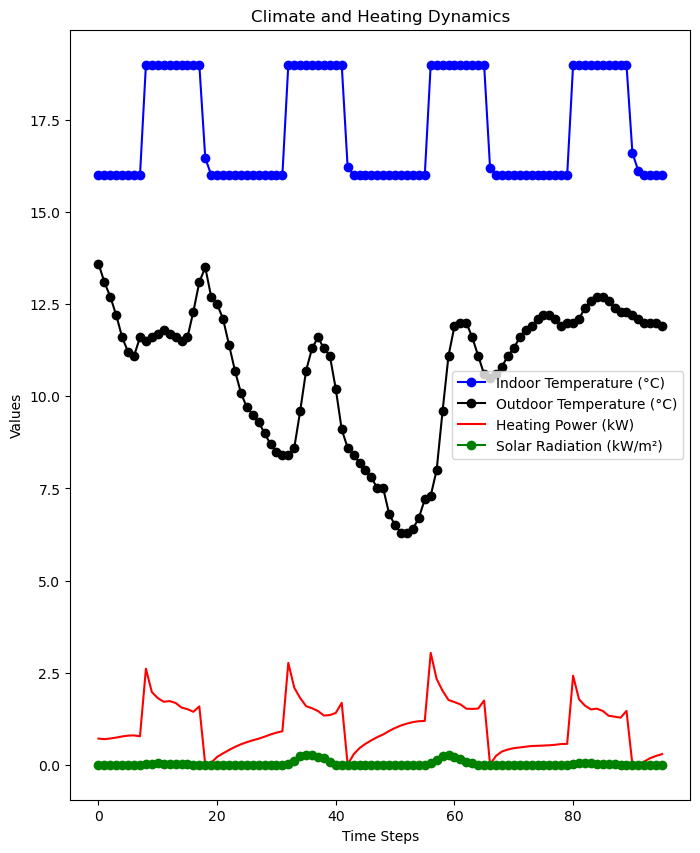

In [39]:
fig, ax = plt.subplots(figsize=(8, 10))

# Graficar con etiquetas
ax.plot(df['Tin'], marker='o', color='blue', label='Indoor Temperature (°C)')
ax.plot(df['Tex'], marker='o', color='black', label='Outdoor Temperature (°C)')
ax.plot(df['P'], color='red', label='Heating Power (kW)')
ax.plot(df['Radiation'], marker='o', color='green', label='Solar Radiation (kW/m²)')

# Añadir leyenda y etiquetas
ax.set_xlabel("Time Steps")
ax.set_ylabel("Values")
ax.set_title("Climate and Heating Dynamics")
ax.legend()

plt.show()

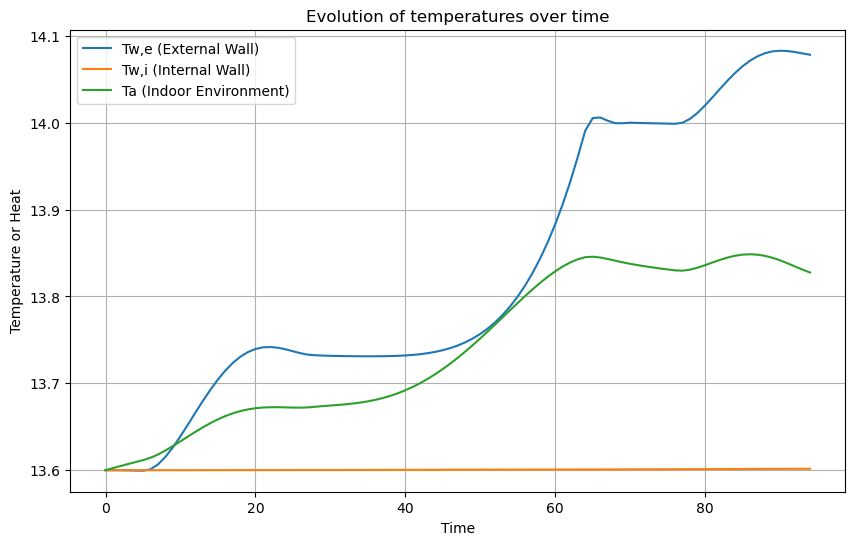

In [6]:
###------------- Variables-----------------####

# Surface areas
As = 95         # Surface flor(m2)
Aw = 110.7      # Surface area of walls (m2)
Afen = 8        # Surface area of windows (m2) 
Ae = 110        # External surface area of walls (m2)
taufen = 0.90   # Transmition coefficient 
alpha_e = 0.2   # Absortion coeffient external wall
alpha_i = 0.4   # Absortion coeffient internal wall

# Thermal properties
Ci = 280.0    # Thermal capacity of air (kJ/K)
Cw = 62.0e3   # Thermal capacity of walls (kJ/K)
Ke = 3.2      # External thermal resistance (kW/K) 
Kw = 25.0e-3  # Thermal resistance of walls (kW/K)
Ki = 3.2      # Internal thermal resistance (kW/K)
m_dot = 55.0e-3  # Infiltration rate (kW/K)

# Initial conditions from data
Twe = df['Tex'].iloc[0]     # External wall temperature
Twi = df['Tex'].iloc[0]     # Internal wall temperature
Ta = df['Tex'].iloc[0]      # Air temperature
X0 = [Ta, Twi, Twe]         # Initial conditions vectori, Twe]   # Initial condition

# Extract data series
E = df['Radiation'].values
Tex = df['Tex'].values
Tin = df['Tin'].values
P = df['P'].values
###------------- MODELO -----------------####


MATRIX_A = [
    [-(m_dot + Ki) / Ci, Ki/Ci, 0],
    [2 * Ki / Cw, -2 * (Kw + Ki) / Cw, 2 * Kw / Cw],
    [0, 2 * Kw / Cw, -2 * (Ke + Kw) / Cw]
]

MATRIX_B = [
    [0, 0, m_dot / Ci],
    [0, 2 / Cw , 0],
    [2 / Cw, 0, 2 * Ke / Cw ]
]


E_func = interp1d(np.arange(len(E)), E, kind='linear', fill_value="extrapolate")
Tex_func = interp1d(np.arange(len(Tex)), Tex, kind='linear', fill_value="extrapolate")
P_func = interp1d(np.arange(len(P)), P, kind='linear', fill_value="extrapolate")

def RC_model(t, X, MATRIX_A, MATRIX_B):
    
    # Evaluar las señales en el tiempo t
    E_t = E_func(t)
    Tex_t = Tex_func(t)
    P_t = P_func(t)

    Ge_t = alpha_e * Ae / (2 * E_t) if E_t != 0 else 0
    Gi_t = taufen * alpha_i * Afen * E_t

    D = np.array([P_t / Ci, 0, 0])
    C = np.array([Ge_t, Gi_t, Tex_t ])

    return MATRIX_A @ X + MATRIX_B @ C + D

# Resolver el sistema
t_span = [0, 95]
t_eval = np.arange(0, 95, 1)

sol = solve_ivp(RC_model, t_span, X0, t_eval=t_eval, args=(MATRIX_A, MATRIX_B))
time = sol.t
T_a, T_w_i, T_w_e = sol.y


# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(time, T_w_e, label="Tw,e (External Wall)")
plt.plot(time, T_w_i, label="Tw,i (Internal Wall)")
plt.plot(time, T_a, label="Ta (Indoor Environment)")
plt.xlabel("Time")
plt.ylabel("Temperature or Heat")
plt.title("Evolution of temperatures over time")
plt.legend()
plt.grid()
plt.show()

Ci: 279.488790
Cw: 61999.999835
Ke: 3.604700
Kw: 0.029226
Ki: 3.014853
m_dot: 0.112493


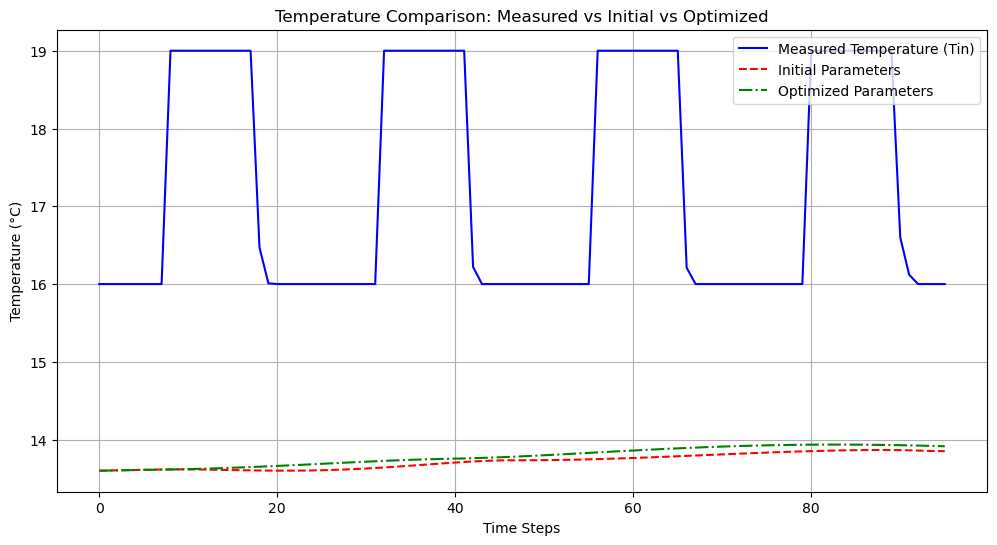


Mean Squared Error Comparison:
Initial parameters MSE: 14.698649
Optimized parameters MSE: 14.256851
Improvement: 3.01%


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import minimize

# Read data
path = r"C:\Users\Alexandra\Documents\TEE-etoile\ProCom\donnes_modele_RC.csv"
df = pd.read_csv(path, delimiter=',')

# Convert units
df['P'] = df['P'] / 1000
df['Radiation'] = df['Radiation'] / 1000

###------------- Variables-----------------####

# Surface areas
As = 95         # Surface floor (m2)
Aw = 110.7      # Surface area of walls (m2)
Afen = 8        # Surface area of windows (m2) 
Ae = 110        # External surface area of walls (m2)
taufen = 0.90   # Transmission coefficient 
alpha_e = 0.2   # Absorption coefficient external wall
alpha_i = 0.4   # Absorption coefficient internal wall

# Initial conditions from data
Twe = df['Tex'].iloc[0]     # External wall temperature
Twi = df['Tex'].iloc[0]     # Internal wall temperature
Ta = df['Tex'].iloc[0]      # Air temperature
X0 = [Ta, Twi, Twe]         # Initial conditions vector

# Extract data series
E = df['Radiation'].values
Tex = df['Tex'].values
Tin = df['Tin'].values
P = df['P'].values

def RC_model_for_optimization(Twe, Twi, Ta, E, Tex, P, params):
    Ci, Cw, Ke, Kw, Ki, m_dot = params

    # System matrices
    MATRIX_A = np.array([
        [-(m_dot + Ki) / Ci, Ki / Ci, 0],
        [2 * Ki / Cw, -2 * (Kw + Ki) / Cw, 2 * Kw / Cw],
        [0, 2 * Kw / Cw, -2 * (Ke + Kw) / Cw]
    ])

    MATRIX_B = np.array([
        [0, 0, m_dot / Ci],
        [0, 2 / Cw, 0],
        [2 / Cw, 0, 2 * Ke / Cw]
    ])

    # Data interpolation
    t = np.arange(len(E))
    E_func = interp1d(t, E, kind='linear', fill_value="extrapolate")
    Tex_func = interp1d(t, Tex, kind='linear', fill_value="extrapolate")
    P_func = interp1d(t, P, kind='linear', fill_value="extrapolate")

    def RC_model(t, X):
        Ta, Twi, Twe = X
        E_t = max(E_func(t), 1e-10)  # Avoid division by zero
        Tex_t = Tex_func(t)
        P_t = P_func(t)

        Ge_t = alpha_e * Ae * E_t / 2
        Gi_t = taufen * alpha_i * Afen * E_t

        D = np.array([P_t / Ci, 0, 0])
        C = np.array([Ge_t, Gi_t, Tex_t])

        return MATRIX_A @ X + MATRIX_B @ C + D

    # Solve the system
    t_span = [0, len(E) - 1]
    t_eval = np.arange(0, len(E), 1)
    sol = solve_ivp(RC_model, t_span, X0, t_eval=t_eval, method='RK45')
    
    return sol.y[0]  # Return simulated temperature (Ta)

def objective_function(params):
    Ta_simulated = RC_model_for_optimization(Twe, Twi, Ta, E, Tex, P, params)
    return np.sum((Ta_simulated - Tin) ** 2)

# Initial parameters
initial_params = [280.0, 62.0e3, 3.2, 25.0e-3, 3.2, 55.0e-3]

# Calculate temperature with initial parameters
Ta_initial = RC_model_for_optimization(Twe, Twi, Ta, E, Tex, P, initial_params)

# Optimization constraints
bounds = [
    (100, 1000),      # Ci bounds
    (10e3, 200e3),    # Cw bounds
    (0.1, 10),        # Ke bounds
    (1e-3, 1),        # Kw bounds
    (0.1, 10),        # Ki bounds
    (1e-3, 1)         # m_dot bounds
]

# Optimization with scipy minimize
result = minimize(
    objective_function,
    initial_params,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 100}
)

# Calculate temperature with optimized parameters
Ta_optimized = RC_model_for_optimization(Twe, Twi, Ta, E, Tex, P, result.x)

# Print results
param_names = ['Ci', 'Cw', 'Ke', 'Kw', 'Ki', 'm_dot']
for name, value in zip(param_names, result.x):
    print(f"{name}: {value:.6f}")


# Create time array for x-axis
time = np.arange(len(Tin))

# Plot results with both initial and optimized parameters
plt.figure(figsize=(12, 6))
plt.plot(time, Tin, label='Measured Temperature (Tin)', color='blue')
plt.plot(time, Ta_initial, label='Initial Parameters', color='red', linestyle='--')
plt.plot(time, Ta_optimized, label='Optimized Parameters', color='green', linestyle='-.')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Comparison: Measured vs Initial vs Optimized')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print MSE for both cases
mse_initial = np.mean((Ta_initial - Tin) ** 2)
mse_optimized = np.mean((Ta_optimized - Tin) ** 2)
print("\nMean Squared Error Comparison:")
print(f"Initial parameters MSE: {mse_initial:.6f}")
print(f"Optimized parameters MSE: {mse_optimized:.6f}")
print(f"Improvement: {((mse_initial - mse_optimized)/mse_initial * 100):.2f}%")